# CM3070 Final Year Project
## Project title: Exploring Facial Recognition: A Comparative Analysis of Machine Learning and Deep Learning Models
<b>Done by: Zou JiaJun</b>
## Import essential libraries

In [1]:
# Necessary libraries and imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Settings and configurations
%matplotlib inline
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Ignore the warning
import warnings
warnings.filterwarnings('ignore')
py.init_notebook_mode(connected=True)

# Machine Learning models
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

# CNN model
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, LeakyReLU, 
    AveragePooling2D)
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

2023-09-19 02:55:33.741190: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data prepartion
- Firstly, load the data from the npy files
- Secondly, print some images in the dataset
- Thirdly, split and shuffle the training set into training and validation sets
- Next, print the shape of training, validaion and testing set.

In [2]:
# Load and inspect the dataset
ds_image = np.load("olivetti_faces.npy")
ds_labels = np.load("olivetti_faces_target.npy")

print("Image:", ds_image.shape)
print("labels:", ds_labels.shape)

Image: (400, 64, 64)
labels: (400,)


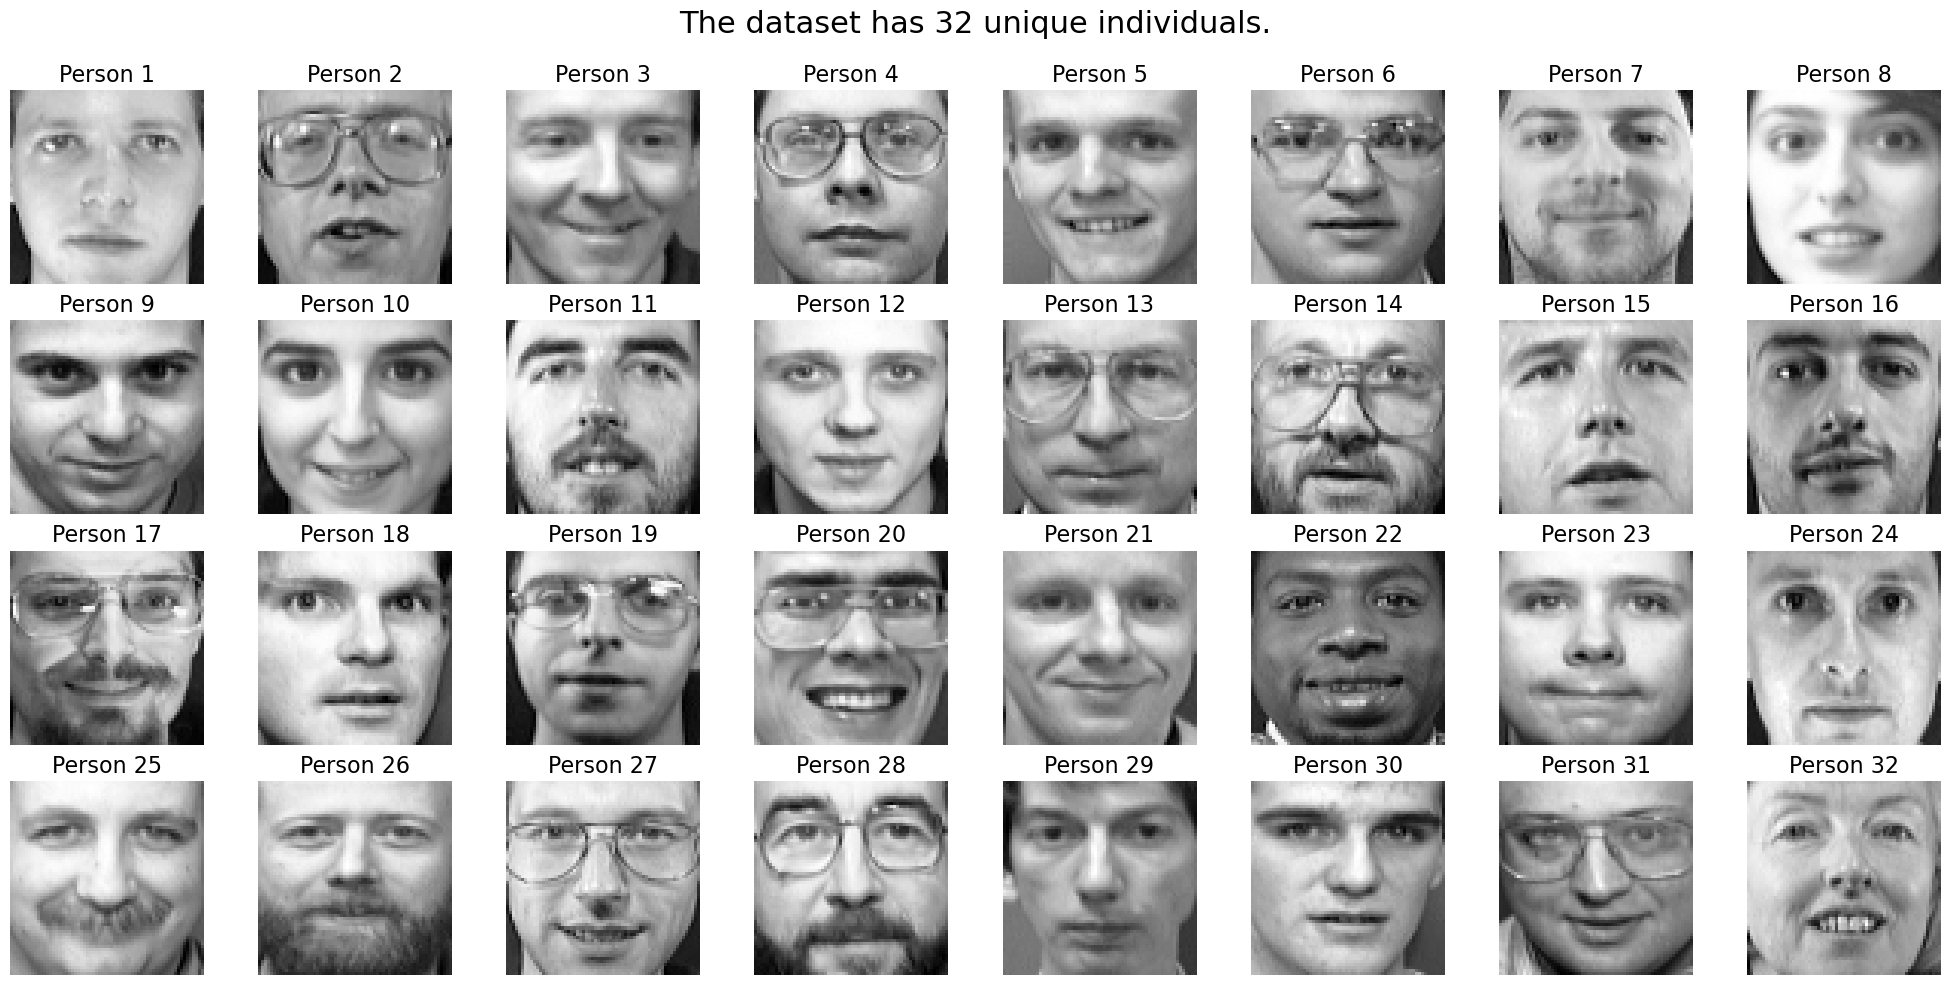

In [3]:
# Check if there are enough images in the dataset
columns = 8
rows = 4

if ds_image.shape[0] < columns*rows:
    print(f"Only {ds_image.shape[0]} images available. Cannot display {columns*rows} images.")
    exit()
    
fig, axes = plt.subplots(rows, columns, figsize=(20, 10))

for i, ax in enumerate(axes.ravel()):
    # Access the image
    img = ds_image[10*i, :, :]
    
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Person {i+1}", fontsize=16)
    ax.axis('off')

# Adjust spacing
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle(f"The dataset has {columns*rows} unique individuals.", fontsize=22)
plt.show()

## Pre-processing data

In [4]:
# Reshape the dataset
ds_X = ds_image
ds_y = ds_labels.reshape(-1, 1)

# Train and split the data
x_train, x_test, y_train, y_test = train_test_split(ds_X, ds_y, test_size=0.2, random_state=46)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])

# Print the dataset
print("x_train:", x_train.shape)
print("x_test:", x_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

x_train: (320, 4096)
x_test: (80, 4096)
y_train: (320, 1)
y_test: (80, 1)


## Testing this dataset using various machine learning models

In [5]:
# Gather the name of the ML models and accuracies 
model_names = []
model_accuracy = []

In [6]:
# Testing dataset using various machine learning models
def evaluate_ml_model(model, x_train, y_train, x_test, y_test, model_name):
    model.fit(x_train, y_train)
    accuracy = round(model.score(x_test, y_test) * 100, 2)
    print(f"Accuracy for {model_name}: {accuracy}%")
    
    # Generate the classification report
    y_pred = model.predict(x_test)
    report = classification_report(y_test, y_pred)
    print(f"Classification Report for {model_name}:\n{report}")
    
    return accuracy

### Model 1: GaussianNB

In [7]:
nb = GaussianNB()
nb.fit(x_train, y_train)
nb_accuracy = round(nb.score(x_test, y_test)*100, 2)
print("Accuracy for GaussianNB:", nb_accuracy, "%")
model_names.append("GaussianNB")
model_accuracy.append(nb_accuracy)

Accuracy for GaussianNB: 87.5 %


### Model 2: DecisionTree

In [8]:
dtr = DecisionTreeClassifier(random_state=0)
dtr.fit(x_train, y_train)
dtr_accuracy = round(dtr.score(x_test, y_test)*100, 2)
print("Accuracy for DecisionTree:", dtr_accuracy, "%")
model_names.append("DecisionTree")
model_accuracy.append(dtr_accuracy)

Accuracy for DecisionTree: 61.25 %


### Model 3: KNN

In [9]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(x_train, y_train)
knn_accuracy = round(knn.score(x_test, y_test)*100, 2)
print("Accuracy for KNN:", knn_accuracy, "%")
model_names.append("KNN")
model_accuracy.append(knn_accuracy)

Accuracy for KNN: 81.25 %


### Model 4: Logistic Regression

In [10]:
lr = LogisticRegression(max_iter=100)
lr.fit(x_train, y_train)
lr_accuracy = round(lr.score(x_test, y_test)*100, 2)
print("Accuracy for Logistic Regression:", lr_accuracy, "%")
model_names.append("Logistic Regression")
model_accuracy.append(lr_accuracy)

Accuracy for Logistic Regression: 96.25 %


In [11]:
# Collarte all the machine learning model accuracy
for name, accuracy in zip(model_names, model_accuracy):
    print(name, accuracy)

GaussianNB 87.5
DecisionTree 61.25
KNN 81.25
Logistic Regression 96.25


## Model 5: CNN
### Pre-processing for CNN

In [12]:
# Constants for CNN
BATCH_SIZE = 20
NUM_CLASSES = 40
LEARNING_RATE = 0.001
VALIDATION_SPLIT = 0.2
EPOCHS = 40

# Prepare data for CNN
def prepare_data_cnn():
    x_data = ds_image.reshape(-1, 64, 64, 1)
    y_data = to_categorical(ds_labels, num_classes=NUM_CLASSES)
    return train_test_split(x_data, y_data, test_size=VALIDATION_SPLIT, random_state=46)

### Build layers and train the model

In [13]:
# Define CNN model
def cnn_model():
    model = Sequential([
        Conv2D(filters=20, kernel_size=(5, 5), padding='Same', activation='relu', input_shape=(64, 64, 1)),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        Conv2D(filters=50, kernel_size=(6, 6), padding='Same', activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        Conv2D(filters=150, kernel_size=(5, 5), padding='Same', activation='relu'),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ])

    optimizer = RMSprop(learning_rate=LEARNING_RATE, rho=0.9, epsilon=1e-08)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    return model

# Train CNN model
def train_cnn_model(epochs, model, x_train, y_train, x_test, y_test):
    datagen = ImageDataGenerator(rotation_range=5, zoom_range=0.05)
    datagen.fit(x_train)

    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.7, min_lr=1e-11)
    history = model.fit(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                        epochs=epochs, validation_data=(x_test, y_test), verbose=2,
                        steps_per_epoch=len(x_train) // BATCH_SIZE,
                        callbacks=[learning_rate_reduction])

    return history, model

### Call the CNN function and craft classification report

In [14]:
if __name__ == "__main__":
    x_train, x_test, y_train, y_test = prepare_data_cnn()
    
    model_names = ["GaussianNB", "DecisionTree", "KNN", "Logistic Regression"]
    classifiers = [GaussianNB(), DecisionTreeClassifier(random_state=0), 
                   KNeighborsClassifier(n_neighbors=7), LogisticRegression(max_iter=100)]
    model_accuracy = []
    classification_reports = {}

    for clf, name in zip(classifiers, model_names):
        clf.fit(x_train.reshape(x_train.shape[0], -1), np.argmax(y_train, axis=1))
        accuracy = round(clf.score(x_test.reshape(x_test.shape[0], -1), np.argmax(y_test, axis=1)) * 100, 2)
        print(f"Accuracy for {name}: {accuracy}%")
        model_accuracy.append(accuracy)
        # Generate the classification report for each model
        y_pred = clf.predict(x_test.reshape(x_test.shape[0], -1))
        report = classification_report(np.argmax(y_test, axis=1), y_pred)
        classification_reports[name] = report
    
    model = cnn_model()
    history, trained_model = train_cnn_model(EPOCHS, model, x_train, y_train, x_test, y_test)
    loss, cnn_accuracy = model.evaluate(x_test, y_test, verbose=0)
    print(f'Validation Accuracy for CNN with {EPOCHS} epochs: {cnn_accuracy*100:.2f}%')
    
    # Evaluate the trained_model on the test set
    test_loss, test_accuracy = trained_model.evaluate(x_test, y_test)
    print(f'Test loss for cnn model: {test_loss:.2f}')
    print(f'Test accuracy for cnn model: {test_accuracy:.2f}')

    model_names.append("CNN")
    model_accuracy.append(round(cnn_accuracy * 100,2))

    # Classification report for CNN
    y_pred_cnn = model.predict(x_test)
    y_true_cnn = np.argmax(y_test, axis=1)
    cnn_classification_report = classification_report(y_true_cnn, np.argmax(y_pred_cnn, axis=1))
    classification_reports["CNN"] = cnn_classification_report

    # Display all classification reports together
    for model_name, report in classification_reports.items():
        print(f"Classification Report for {model_name}:\n{report}")

Accuracy for GaussianNB: 87.5%
Accuracy for DecisionTree: 61.25%
Accuracy for KNN: 81.25%
Accuracy for Logistic Regression: 96.25%
Epoch 1/40
16/16 - 4s - loss: 4.5257 - accuracy: 0.0156 - val_loss: 3.6917 - val_accuracy: 0.0375 - lr: 0.0010 - 4s/epoch - 230ms/step
Epoch 2/40
16/16 - 2s - loss: 3.6882 - accuracy: 0.0250 - val_loss: 3.6996 - val_accuracy: 0.0375 - lr: 0.0010 - 2s/epoch - 150ms/step
Epoch 3/40
16/16 - 2s - loss: 3.6966 - accuracy: 0.0094 - val_loss: 3.6938 - val_accuracy: 0.0125 - lr: 0.0010 - 2s/epoch - 151ms/step
Epoch 4/40

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
16/16 - 2s - loss: 3.7153 - accuracy: 0.0250 - val_loss: 3.6933 - val_accuracy: 0.0000e+00 - lr: 0.0010 - 2s/epoch - 148ms/step
Epoch 5/40
16/16 - 2s - loss: 3.6917 - accuracy: 0.0250 - val_loss: 3.6986 - val_accuracy: 0.0000e+00 - lr: 7.0000e-04 - 2s/epoch - 147ms/step
Epoch 6/40
16/16 - 2s - loss: 3.6820 - accuracy: 0.0437 - val_loss: 3.7557 - val_accuracy: 0.0000e+00 - l

### Create a graph to observe the number of epochs and accuracy.

In [15]:
# Create a epochs VS accuracy 
def plot_accuracy(history):
    val_accuracy = history.history['val_accuracy']
    accuracy = [round(100*a, 3) for a in val_accuracy]
    num_of_epochs = list(range(1, EPOCHS+1))
    trace = go.Scatter(y=accuracy, x=num_of_epochs, mode="lines")
    
    layout = dict(title='CNN Accuracy', autosize=False, width=800, height=500,
                  yaxis=dict(title='Accuracy (%)', gridwidth=2, gridcolor='#bdbdbd'),
                  xaxis=dict(title='Number of Epochs', gridwidth=2, gridcolor='#bdbdbd'),
                  font=dict(size=14))
    
    fig = dict(data=[trace], layout=layout)
    py.iplot(fig)

# Plot the graph
plot_accuracy(history)

## Plotting result of all models

In [16]:
def plot_method_comparison(model_names, model_accuracy):
    df = pd.DataFrame({'METHOD': model_names, 'ACCURACY (%)': model_accuracy})
    df = df.sort_values(by=['ACCURACY (%)']).reset_index(drop=True)
    
    # Bar trace for methods
    bar_trace = go.Bar(x=df['METHOD'], y=df['ACCURACY (%)'], 
                       marker_color='rgb(55, 83, 109)', text=df['ACCURACY (%)'],
                       textposition='outside', name='Accuracy Bar')
    
    # Line trace for accuracies
    line_trace = go.Scatter(x=df['METHOD'], y=df['ACCURACY (%)'], mode='lines+markers',
                            marker=dict(size=10), line=dict(color='red', width=2), 
                            name='Accuracy Line')
    
    layout = go.Layout(title='Comparison of the Learning Methods',
                       xaxis=dict(title='Methods', titlefont=dict(size=16)),
                       yaxis=dict(title='ACCURACY (%)', gridwidth=1, gridcolor='#bdbdbd', range=[55, 105]),
                       font=dict(size=16), bargap=0.2, barmode='overlay')
    
    fig = go.Figure(data=[bar_trace, line_trace], layout=layout)
    py.iplot(fig, filename='grouped-bar')

# Calling the function
plot_method_comparison(model_names, model_accuracy)


In summary, the Convolutional Neural Network (CNN) consistently scored the highest score for accuracy in our early tests, making it clear that it is the most appropriate choice for the task of face recognition.

Because CNN does a better job of recognising faces, I have started to look deeply into the different ways methods can be set up. My goal is to learn more about the differences between overfitting, a simpler CNN model, and the original CNN model by using what I've learned about validation loss and validation accuracy. The goal of this complex study is to figure out which model works best for face recognition.

### Scaling up: developing a model that overfits
- Uses LeakyReLU activation instead of ReLU activation
- More dropout layers
- Difference in number of filters

In [17]:
# Build adjusted model
def adjusted_model():
    """Define an adjusted CNN model."""
    model = Sequential([
        Conv2D(32, (5, 5), padding='Same', input_shape=(64, 64, 1)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        AveragePooling2D((2, 2)),
        Dropout(0.3),

        Conv2D(64, (3, 3), padding='Same', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        AveragePooling2D((2, 2)),
        Dropout(0.3),

        Conv2D(128, (3, 3), padding='Same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        AveragePooling2D((2, 2)),
        Dropout(0.3),

        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    
    optimizer = RMSprop(learning_rate=LEARNING_RATE, rho=0.9, epsilon=1e-08)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    return model

# Train adjusted model
def adj_train_model(epochs, model, x_train, y_train, x_test, y_test):
    """Train the CNN model."""
    datagen = ImageDataGenerator(rotation_range=5, zoom_range=0.05)
    datagen.fit(x_train)

    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.7, min_lr=1e-11)
    
    history_adj = model.fit(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                        epochs=EPOCHS,
                        validation_data=(x_test, y_test),
                        verbose=2,
                        steps_per_epoch=len(x_train) // BATCH_SIZE,
                        callbacks=[learning_rate_reduction])
    return history_adj, model

# Main execution for adjusted model
if __name__ == "__main__":
    # Assuming prepare_data function is elsewhere in your code
    x_train, x_test, y_train, y_test = prepare_data_cnn()
    
    adj_model = adjusted_model()
    history_adj, trained_model = adj_train_model(EPOCHS, adj_model, x_train, y_train, x_test, y_test)
    
    loss, accuracy = trained_model.evaluate(x_test, y_test, verbose=0)
    print(f'Validation Accuracy for adjusted CNN model {EPOCHS} epochs: {accuracy*100:.2f}%')
    
    # Evaluate the trained_model on the test set
    test_loss_adjusted, test_accuracy_adjusted = trained_model.evaluate(x_test, y_test)
    print(f'Test loss for adjusted model: {test_loss_adjusted:.2f}')
    print(f'Test accuracy for adjusted model: {test_accuracy_adjusted:.2f}')

Epoch 1/40
16/16 - 4s - loss: 7.6725 - accuracy: 0.0812 - val_loss: 4.0738 - val_accuracy: 0.0375 - lr: 0.0010 - 4s/epoch - 227ms/step
Epoch 2/40
16/16 - 2s - loss: 3.2966 - accuracy: 0.2594 - val_loss: 4.0471 - val_accuracy: 0.0750 - lr: 0.0010 - 2s/epoch - 152ms/step
Epoch 3/40
16/16 - 2s - loss: 2.7159 - accuracy: 0.3688 - val_loss: 3.9973 - val_accuracy: 0.0750 - lr: 0.0010 - 2s/epoch - 150ms/step
Epoch 4/40
16/16 - 2s - loss: 2.3534 - accuracy: 0.4625 - val_loss: 4.5145 - val_accuracy: 0.0125 - lr: 0.0010 - 2s/epoch - 154ms/step
Epoch 5/40

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
16/16 - 2s - loss: 1.6909 - accuracy: 0.6125 - val_loss: 5.6996 - val_accuracy: 0.0125 - lr: 0.0010 - 2s/epoch - 151ms/step
Epoch 6/40
16/16 - 2s - loss: 1.3220 - accuracy: 0.6812 - val_loss: 6.3211 - val_accuracy: 0.0125 - lr: 7.0000e-04 - 2s/epoch - 142ms/step
Epoch 7/40
16/16 - 2s - loss: 1.0819 - accuracy: 0.7844 - val_loss: 7.9792 - val_accuracy: 0.0125 - lr: 7.000

### Scaling down: developing a model that is less complex than the original model
- lesser convolutional layers, filters
- lesser kernel size

In [18]:
# Build lighter cnn model
def lighter_model():
    """Define a lighter CNN model."""
    model = Sequential([
        # 1st Conv layer
        Conv2D(16, (3, 3), padding='Same', activation='relu', input_shape=(64, 64, 1)),
        MaxPooling2D((2, 2)),
        Dropout(0.2),

        # 2nd Conv layer
        Conv2D(32, (3, 3), padding='Same', activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),

        # Flatten & Dense layers
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.4),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    
    optimizer = RMSprop(learning_rate=LEARNING_RATE, rho=0.9, epsilon=1e-08)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    
    return model

# Train ligher cnn model
def lighter_train_model(epochs, model, x_train, y_train, x_test, y_test):
    """Train the CNN model."""
    datagen = ImageDataGenerator(rotation_range=5, zoom_range=0.05)
    datagen.fit(x_train)

    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.7, min_lr=1e-11)
    
    history_light = model.fit(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                        epochs=EPOCHS,
                        validation_data=(x_test, y_test),
                        verbose=2,
                        steps_per_epoch=len(x_train) // BATCH_SIZE,
                        callbacks=[learning_rate_reduction])
    return history_light, model

# Main execution for lighter model
if __name__ == "__main__":
    # Assuming prepare_data function is elsewhere in your code
    x_train, x_test, y_train, y_test = prepare_data_cnn()
    
    model_light = lighter_model()
    # Corrected the function name here to lighter_train_model
    history_light, trained_model = lighter_train_model(EPOCHS, model_light, x_train, y_train, x_test, y_test)
    
    loss, accuracy = trained_model.evaluate(x_test, y_test, verbose=0)
    print(f'Validation Accuracy for lighter CNN model after {EPOCHS} epochs: {accuracy*100:.2f}%')
    
    # Evaluate the trained_model on the test set
    test_loss_light, test_accuracy_light = trained_model.evaluate(x_test, y_test)
    print(f'Test loss for lighter model: {test_loss_light:.2f}')
    print(f'Test accuracy for lighter model: {test_accuracy_light:.2f}')

Epoch 1/40
16/16 - 1s - loss: 3.7451 - accuracy: 0.0156 - val_loss: 3.6890 - val_accuracy: 0.0000e+00 - lr: 0.0010 - 1s/epoch - 65ms/step
Epoch 2/40
16/16 - 0s - loss: 3.6958 - accuracy: 0.0188 - val_loss: 3.6903 - val_accuracy: 0.0250 - lr: 0.0010 - 419ms/epoch - 26ms/step
Epoch 3/40
16/16 - 0s - loss: 3.6877 - accuracy: 0.0281 - val_loss: 3.6903 - val_accuracy: 0.0250 - lr: 0.0010 - 412ms/epoch - 26ms/step
Epoch 4/40
16/16 - 0s - loss: 3.6831 - accuracy: 0.0281 - val_loss: 3.6902 - val_accuracy: 0.0000e+00 - lr: 0.0010 - 411ms/epoch - 26ms/step
Epoch 5/40

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
16/16 - 0s - loss: 3.6770 - accuracy: 0.0437 - val_loss: 3.6906 - val_accuracy: 0.0125 - lr: 0.0010 - 410ms/epoch - 26ms/step
Epoch 6/40
16/16 - 0s - loss: 3.6684 - accuracy: 0.0375 - val_loss: 3.6820 - val_accuracy: 0.0000e+00 - lr: 7.0000e-04 - 416ms/epoch - 26ms/step
Epoch 7/40
16/16 - 0s - loss: 3.6413 - accuracy: 0.0594 - val_loss: 3.6651 - val_accurac

### Compare the all three models' accuracy.

In [19]:
def plot_accuracies_together(history1, history2, history3, labels=['CNN', 'adjusted_CNN', 'lighter_CNN']):
    """Plot accuracies for three histories on a single graph using Plotly."""
    
    fig = make_subplots(rows=1, cols=1)
    
    histories = [history1, history2, history3]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Distinct colors for each model
    line_styles = ['solid', 'dot', 'dash']  # Distinct line styles for each model

    for i, history in enumerate(histories):
        val_accuracy = history.history['val_accuracy']
        accuracy = [round(100 * a, 3) for a in val_accuracy]
        num_of_epochs = list(range(1, len(val_accuracy) + 1))

        trace = go.Scatter(
            y=accuracy, 
            x=num_of_epochs, 
            mode="lines", 
            name=labels[i], 
            line=dict(color=colors[i], width=2.5, dash=line_styles[i])
        )

        fig.add_trace(trace)

    fig.update_yaxes(title_text="Accuracy (%)")
    fig.update_xaxes(title_text="Number of Epochs")
    fig.update_layout(
        title_text="CNN Accuracy Comparisons",
        autosize=False,
        width=800,
        height=500,
        legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1)
    )
    fig.show()

# Calling the function
plot_accuracies_together(history, history_adj, history_light)

### Build a graph of validation loss and accuracy for comparison purposes.

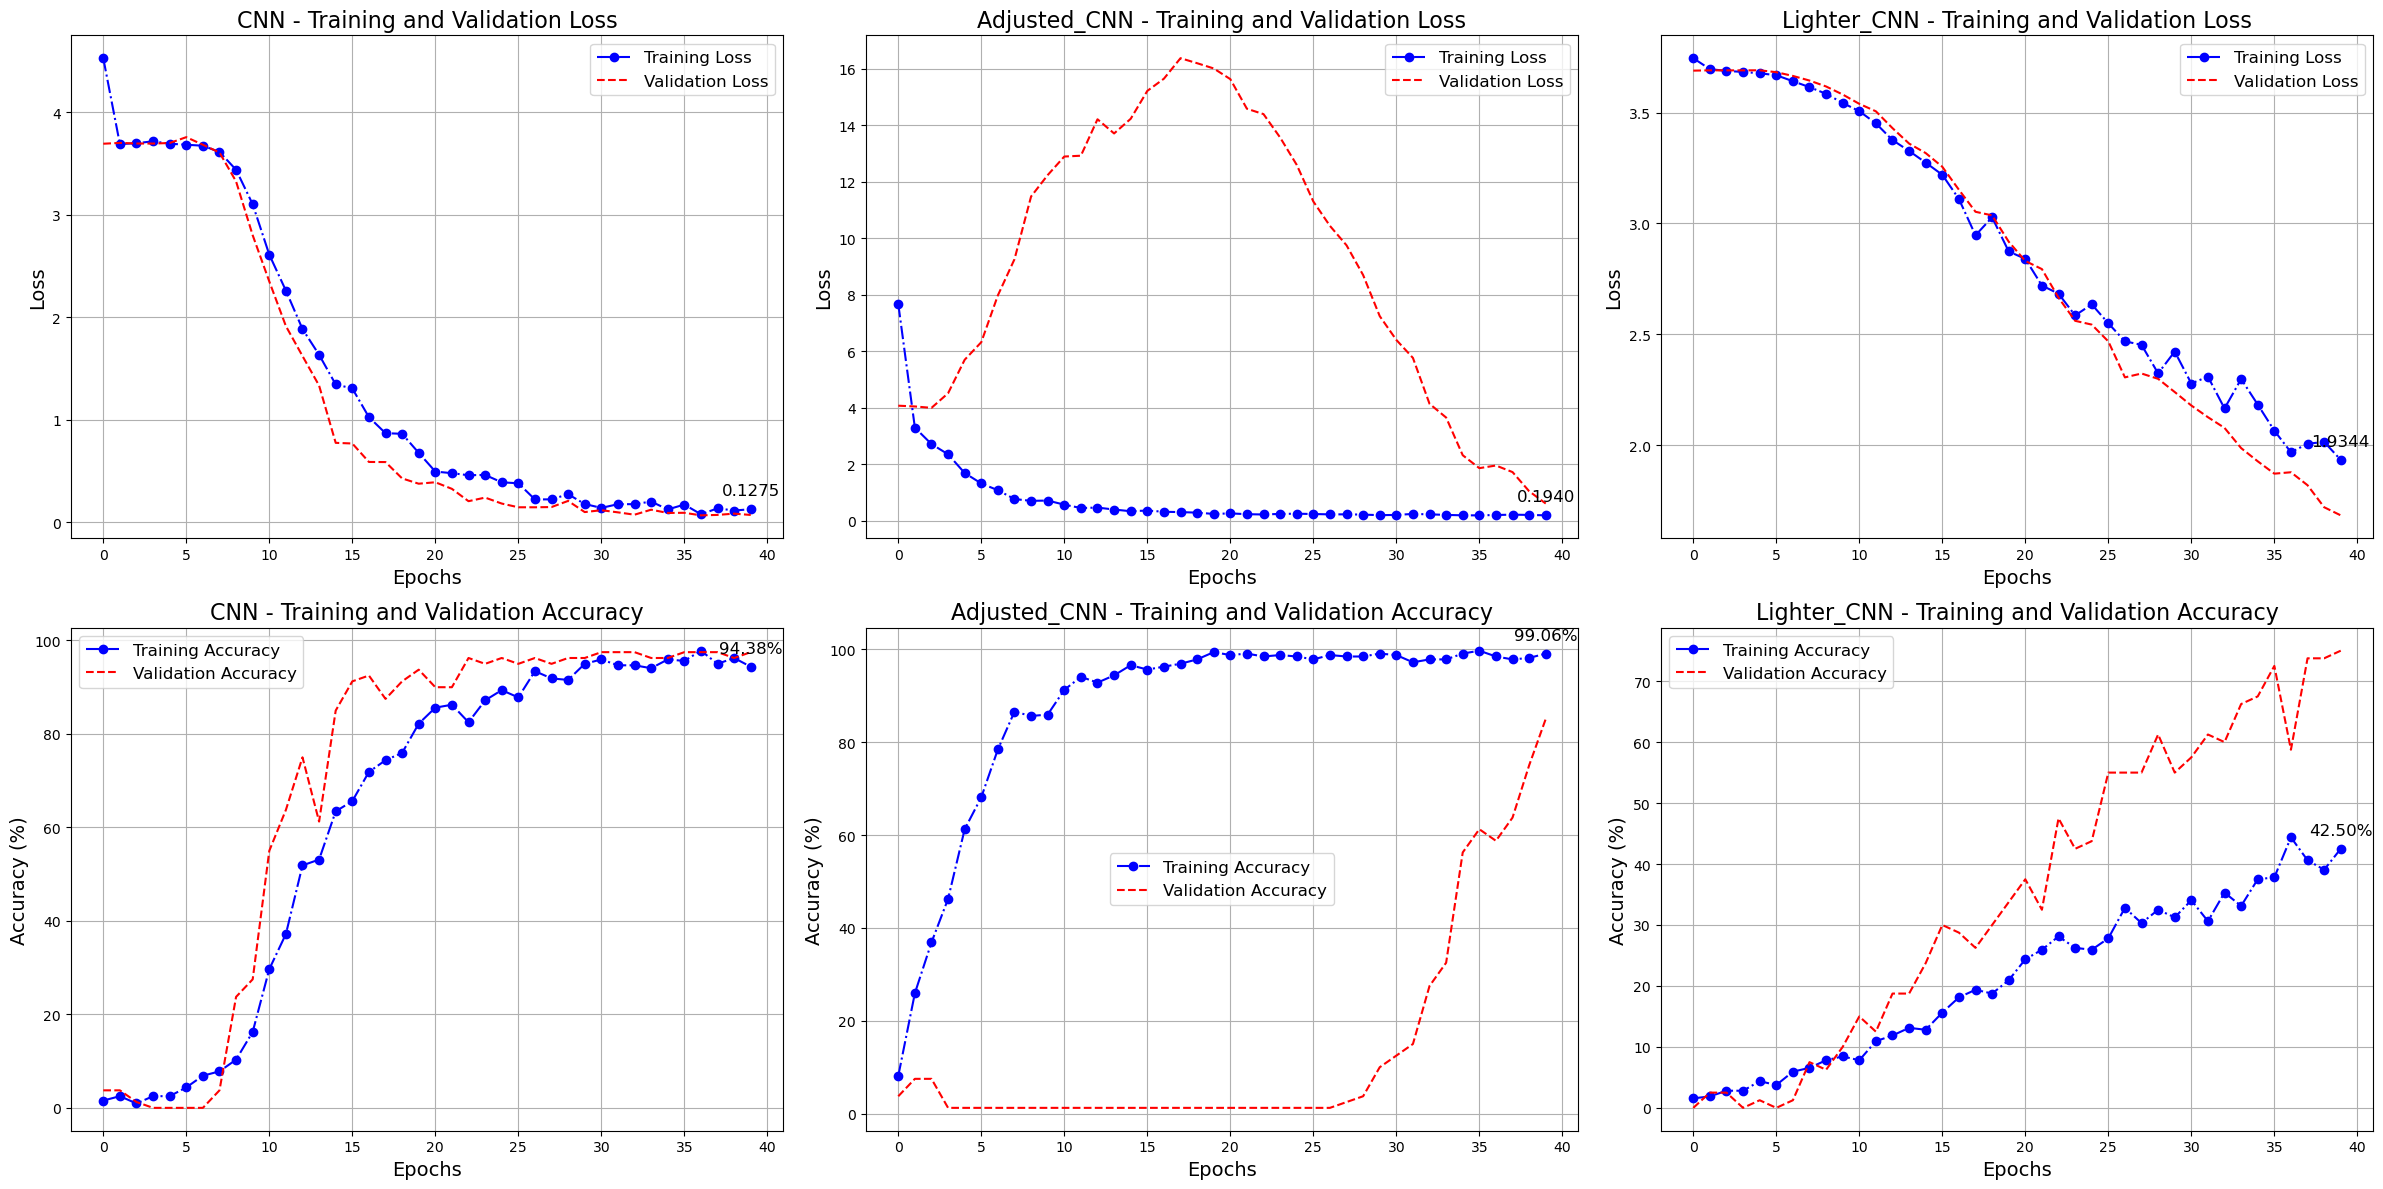

In [20]:
def plot_loss_accuracy_together(history1, history2, history3, labels=['CNN', 'Adjusted_CNN', 'Lighter_CNN']):
    """Plot training and validation loss and accuracy for three histories together."""
    fig, axs = plt.subplots(2, 3, figsize=(24, 12))  # 2 rows, 3 columns

    histories = [history1, history2, history3]

    for i, history in enumerate(histories):
        # Loss Plot
        axs[0, i].plot(history.epoch, history.history['loss'], 'bo-.', label="Training Loss", linewidth=1.5, markersize=6)
        axs[0, i].plot(history.epoch, history.history['val_loss'], 'r--', label="Validation Loss", linewidth=1.5)
        axs[0, i].set_title(f'{labels[i]} - Training and Validation Loss', fontsize=16)
        axs[0, i].set_xlabel('Epochs', fontsize=14)
        axs[0, i].set_ylabel('Loss', fontsize=14)
        axs[0, i].legend(fontsize=12)
        axs[0, i].grid(True)

        # Accuracy Plot
        train_accuracy_percent = [acc * 100 for acc in history.history['accuracy']]
        val_accuracy_percent = [acc * 100 for acc in history.history['val_accuracy']]
        axs[1, i].plot(history.epoch, train_accuracy_percent, 'bo-.', label="Training Accuracy", linewidth=1.5, markersize=6)
        axs[1, i].plot(history.epoch, val_accuracy_percent, 'r--', label="Validation Accuracy", linewidth=1.5)
        axs[1, i].set_title(f'{labels[i]} - Training and Validation Accuracy', fontsize=16)
        axs[1, i].set_xlabel('Epochs', fontsize=14)
        axs[1, i].set_ylabel('Accuracy (%)', fontsize=14)
        axs[1, i].legend(fontsize=12)
        axs[1, i].grid(True)

        # For aesthetics: you can comment this out if you don't need value annotations on the plots.
        # It annotates the final epoch values for both plots.
        for ax, metric, value in zip([axs[0, i], axs[1, i]],
                                     ['loss', 'accuracy'],
                                     [history.history['loss'][-1], train_accuracy_percent[-1]]):
            ax.annotate(f"{value:.4f}" if metric == 'loss' else f"{value:.2f}%",
                        (len(history.epoch) - 1, value),
                        textcoords="offset points",
                        xytext=(0, 10),
                        ha='center',
                        fontsize=12)

    plt.tight_layout()
    plt.show()

# Calling the function
plot_loss_accuracy_together(history, history_adj, history_light)

## Conclusion

| Model           | Test Accuracy | Test Loss | 
|-----------------|---------------|-----------|
| CNN Model       | 0.98          | 0.07      |
| Adjusted Model  | 0.85          | 0.61      |
| Lighter Model   | 0.75          | 1.68      |

- The CNN model had a test accuracy of 0.98, which means it almost correctly identified all of the test samples. This is a very high accuracy score, indicating that the model performed remarkably well on the test data. The model's high performance is further confirmed by the minimal test loss of 0.07.

- In comparison, the Lighter model has a substantially lower test accuracy of 0.75 and a significantly larger test loss of 1.68. These findings show that the Lighter model performs poorly on the test data. Its accuracy is comparable to random guessing, and the large loss indicates that it makes major categorization mistakes.

- In terms of performance, the Adjusted model lies in between the CNN and Lighter models. It scored a test accuracy of 0.85, suggesting that it performed pretty well. The test loss of 0.61 indicates that it makes some mistakes, but not as many as the Lighter model.


In conclusion, based on the test results presented, the CNN model is the best-performing model for the given task. It has a nealry flawless test accuracy of 0.98 and a very low test loss of 0.07, suggesting its outstanding ability to correctly recognise the test data. The Lighter model performs badly, while the Adjusted model performs somewhat but lacks the precision of the CNN model.